In [25]:
from PIL import Image
from torchvision import transforms
from transformers import AutoModelForObjectDetection
import torch
import os
import fitz  # PyMuPDF
import glob
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
# Get a list of all .pdf files in the current directory
pdf_files = glob.glob('*.pdf')

pdf_documents = [file for file in pdf_files]
pdf_documents

['2022-annual-report-wf.pdf', '2022-annual-report-bofa.pdf']

In [27]:
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize(
            (int(round(scale * width)), int(round(scale * height)))
        )

        return resized_image


detection_transform = transforms.Compose(
    [
        MaxResize(800),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

structure_transform = transforms.Compose(
    [
        MaxResize(1000),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# load table detection model
# processor = TableTransformerImageProcessor(max_size=800)
model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection", revision="no_timm"
).to(device)

# load table structure recognition model
# structure_processor = TableTransformerImageProcessor(max_size=1000)
structure_model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-structure-recognition-v1.1-all"
).to(device)

In [32]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    width, height = size
    boxes = box_cxcywh_to_xyxy(out_bbox)
    boxes = boxes * torch.tensor([width, height, width, height], dtype=torch.float32)
    return boxes


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs["pred_boxes"].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == "no object":
            objects.append(
                {
                    "label": class_label,
                    "score": float(score),
                    "bbox": [float(elem) for elem in bbox],
                }
            )

    return objects


def detect_and_crop_save_table(image, cropped_table_directory="./table_images/"):

    if not os.path.exists(cropped_table_directory):
        os.makedirs(cropped_table_directory)

    # prepare image for the model
    # pixel_values = processor(image, return_tensors="pt").pixel_values
    pixel_values = detection_transform(image).unsqueeze(0).to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values)

    # postprocess to get detected tables
    id2label = model.config.id2label
    id2label[len(model.config.id2label)] = "no object"
    detected_tables = outputs_to_objects(outputs, image.size, id2label)

    print(f"number of tables detected {len(detected_tables)}")

    for idx in range(len(detected_tables)):
        #   # crop detected table out of image
        cropped_table = image.crop(detected_tables[idx]["bbox"])
        cropped_table.save(f"./{cropped_table_directory}/test_{idx}.png")


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

In [36]:
doc = fitz.open(pdf_documents[0])
page = doc.load_page(19)
page.get_text()

'Noninterest Income \n \n   \n \nTable 5: Noninterest Income \n \n \n \nYear ended December 31, \n \n(in millions) \n2022 \n2021 \n \n$ Change \n2022/ \n2021 \n \n% Change \n2022/ \n2021 \n2020 \n \n$ Change \n2021/ \n2020 \n \n% Change \n2021/ \n2020 \n \nDeposit-related fees \n $ \n \n5,316 \n \n5,475 \n \n(159) \n \n \n(3)% \n \n$ \n \n5,221 \n \n254 \n  \n5 % \n \nLending-related fees \n \n1,397 \n \n1,445 \n \n(48) \n \n \n(3) \n \n1,381 \n \n64 \n  \n5 \n \n \n \n \n \n \nInvestment advisory and other asset-based fees \n \n9,004 \n \n11,011 \n \n(2,007) \n \n \n(18) \n \n9,863 \n \n1,148 \n \n \n12 \n \n \n \n \n \nCommissions and brokerage services fees \n \n2,242 \n \n2,299 \n \n(57) \n \n \n(2) \n \n2,384 \n \n(85) \n \n \n(4) \n \n \nInvestment banking fees \n \n1,439 \n \n2,354 \n \n(915) \n \n \n(39) \n \n1,865 \n \n489 \n \n \n26 \n \nCard fees \n \n4,355 \n \n4,175 \n \n180 \n  \n4 \n \n3,544 \n \n631 \n \n \n18 \n \n \nNet servicing income \n \n533 \n \n194 \n \n339 \n \

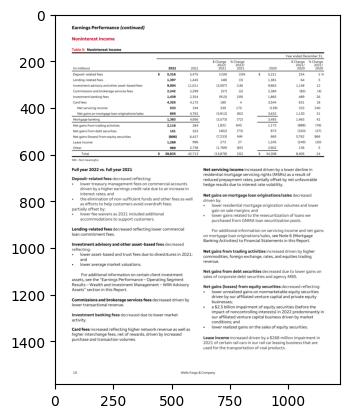

In [30]:
pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))
image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
plt.imshow(image)


In [33]:
detect_and_crop_save_table(image)

number of tables detected 1
